For dataset and Info  -->  
https://archive.ics.uci.edu/dataset/222/bank+marketing

# Data Preprocessing


## Library import


In [4]:
#!pip install category_encoders

In [77]:
import pandas as pd
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier,plot_importance
from category_encoders.target_encoder import TargetEncoder
import warnings 

In [6]:
warnings.filterwarnings('ignore')

## Data import


In [8]:
df = pd.read_csv('./bank-additional-full.csv',delimiter=';')

## EDA(exploratory data analysis)


In [10]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [11]:
df.shape

(41188, 21)

In [12]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [13]:
df.y.unique()

array(['no', 'yes'], dtype=object)

## Feature engineering



Lets drop some columns that doesn't gonna affect the Output

In [16]:
cols_to_drop = ['duration','emp.var.rate','cons.conf.idx','euribor3m','nr.employed']

In [17]:
df = df.drop(cols_to_drop,axis = 1).rename(columns={'job': 'job_type', 'default': 'default_status',
                                                   'housing': 'housing_loan_status', 'loan': 'personal_loan_status',
                                                   'contact': 'contact_type', 'month': 'contact_month',
                                                   'day_of_week': 'contact_day_of_week', 'campaign': 'num_contacts',
                                                   'pdays': 'days_last_contact', 'previous': 'previous_contacts',
                                                   'poutcome': 'previous_outcome',
                                                   'y': 'result'
                                                    })

In [18]:
df['result'] = df['result'].replace({'yes':1,'no':0})

In [19]:
df = df.drop('cons.price.idx',axis = 1)

In [20]:
df.head()

,age,job_type,marital,education,default_status,housing_loan_status,personal_loan_status,contact_type,contact_month,contact_day_of_week,num_contacts,days_last_contact,previous_contacts,previous_outcome,result
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,0


In [21]:
df.shape

(41188, 15)

In [22]:
df.result.value_counts()

result
0    36548
1     4640
Name: count, dtype: int64

# Model building


## Train_test_split


In [25]:
x = df.drop('result',axis = 1)
y = df.result

In [26]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,stratify = y,random_state=0)

## Model initialization


EXAMPLE OF **TargetEncoding**

In [29]:
df = pd.DataFrame({
    'feature': ['a', 'b', 'c', 'a', 'b', 'c'],
    'target':  [1, 0, 1, 0, 1, 0]
})
X = df[['feature']]  # must be a DataFrame
y = df['target']     # target values
encoder = TargetEncoder(cols=['feature'])
X_encoded = encoder.fit_transform(X, y)

print(X_encoded)


   feature
0      0.5
1      0.5
2      0.5
3      0.5
4      0.5
5      0.5


In [30]:
estimators = [
  ('encoder',TargetEncoder()),
    ('clf',XGBClassifier(random_state = 8))
]
pipe = Pipeline(estimators)
pipe

,steps,"[('encoder', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,verbose,0
,cols,None
,drop_invariant,False
,return_df,True
,handle_missing,'value'
,handle_unknown,'value'
,min_samples_leaf,20


## Hyper parameter tuning



In [58]:
search_space = {
    'clf__max_depth': [3, 5, 7],
    'clf__learning_rate': [0.01, 0.1, 0.3],
    'clf__subsample': [0.7, 0.9],
    'clf__colsample_bytree': [0.7, 0.9],
    'clf__colsample_bylevel': [0.7, 0.9],
    'clf__colsample_bynode': [0.7, 0.9],
    'clf__reg_alpha': [0.0, 1.0, 5.0],
    'clf__reg_lambda': [1.0, 5.0],
    'clf__gamma': [0.0, 1.0, 3.0]
}


grid = GridSearchCV(pipe, search_space, cv=3, scoring='roc_auc', verbose=1, n_jobs=-1)


In [61]:
grid.fit(x_train,y_train)

Fitting 3 folds for each of 2592 candidates, totalling 7776 fits


,estimator,"Pipeline(step...=None, ...))])"
,param_grid,"{'clf__colsample_bylevel': [0.7, 0.9], 'clf__colsample_bynode': [0.7, 0.9], 'clf__colsample_bytree': [0.7, 0.9], 'clf__gamma': [0.0, 1.0, ...], ...}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,verbose,0


## Performance checking


In [69]:
dt = pd.DataFrame(grid.cv_results_)
dt

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__colsample_bylevel,param_clf__colsample_bynode,param_clf__colsample_bytree,param_clf__gamma,param_clf__learning_rate,param_clf__max_depth,param_clf__reg_alpha,param_clf__reg_lambda,param_clf__subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,1.340709,0.012762,0.109669,0.004110,0.7,0.7,0.7,0.0,0.01,3,0.0,1.0,0.7,"{'clf__colsample_bylevel': 0.7, 'clf__colsampl...",0.766552,0.751477,0.761163,0.759731,0.006237,2272
1,1.238758,0.053817,0.115846,0.005685,0.7,0.7,0.7,0.0,0.01,3,0.0,1.0,0.9,"{'clf__colsample_bylevel': 0.7, 'clf__colsampl...",0.768483,0.750887,0.760910,0.760093,0.007207,2244
2,1.218841,0.032901,0.135559,0.020882,0.7,0.7,0.7,0.0,0.01,3,0.0,5.0,0.7,"{'clf__colsample_bylevel': 0.7, 'clf__colsampl...",0.771880,0.749516,0.761383,0.760926,0.009136,2214
3,1.226294,0.026166,0.137392,0.019102,0.7,0.7,0.7,0.0,0.01,3,0.0,5.0,0.9,"{'clf__colsample_bylevel': 0.7, 'clf__colsampl...",0.771971,0.750989,0.760846,0.761269,0.008571,2208
4,1.234859,0.013510,0.118383,0.015022,0.7,0.7,0.7,0.0,0.01,3,1.0,1.0,0.7,"{'clf__colsample_bylevel': 0.7, 'clf__colsampl...",0.771706,0.750889,0.760204,0.760933,0.008514,2213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2587,1.156171,0.013204,0.104000,0.012568,0.9,0.9,0.9,3.0,0.30,7,1.0,5.0,0.9,"{'clf__colsample_bylevel': 0.9, 'clf__colsampl...",0.780549,0.766752,0.779201,0.775501,0.006210,72
2588,1.170185,0.015006,0.098668,0.004923,0.9,0.9,0.9,3.0,0.30,7,5.0,1.0,0.7,"{'clf__colsample_bylevel': 0.9, 'clf__colsampl...",0.777163,0.764037,0.776109,0.772437,0.005955,750
2589,1.149368,0.029380,0.102335,0.008994,0.9,0.9,0.9,3.0,0.30,7,5.0,1.0,0.9,"{'clf__colsample_bylevel': 0.9, 'clf__colsampl...",0.779354,0.762351,0.777278,0.772994,0.007573,594
2590,1.179331,0.006945,0.095003,0.003558,0.9,0.9,0.9,3.0,0.30,7,5.0,5.0,0.7,"{'clf__colsample_bylevel': 0.9, 'clf__colsampl...",0.779870,0.763462,0.774782,0.772705,0.006858,666


In [71]:
grid.best_params_

{'clf__colsample_bylevel': 0.9,
 'clf__colsample_bynode': 0.9,
 'clf__colsample_bytree': 0.7,
 'clf__gamma': 3.0,
 'clf__learning_rate': 0.1,
 'clf__max_depth': 7,
 'clf__reg_alpha': 0.0,
 'clf__reg_lambda': 1.0,
 'clf__subsample': 0.9}

In [75]:
grid.best_score_

0.7772777516021702

In [81]:
grid.best_estimator_.steps

[('encoder',
  TargetEncoder(cols=['job_type', 'marital', 'education', 'default_status',
                      'housing_loan_status', 'personal_loan_status',
                      'contact_type', 'contact_month', 'contact_day_of_week',
                      'previous_outcome'])),
 ('clf',
  XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=0.9, colsample_bynode=0.9, colsample_bytree=0.7,
                device=None, early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, feature_weights=None,
                gamma=3.0, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=0.1, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=7, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators

In [83]:
grid.best_estimator_.steps[1]

('clf',
 XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=0.9, colsample_bynode=0.9, colsample_bytree=0.7,
               device=None, early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, feature_types=None, feature_weights=None,
               gamma=3.0, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.1, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=7, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, ...))

In [85]:
s = grid.best_estimator_.steps[1]
res = s[1]
res

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,0.9
,colsample_bynode,0.9
,colsample_bytree,0.7
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

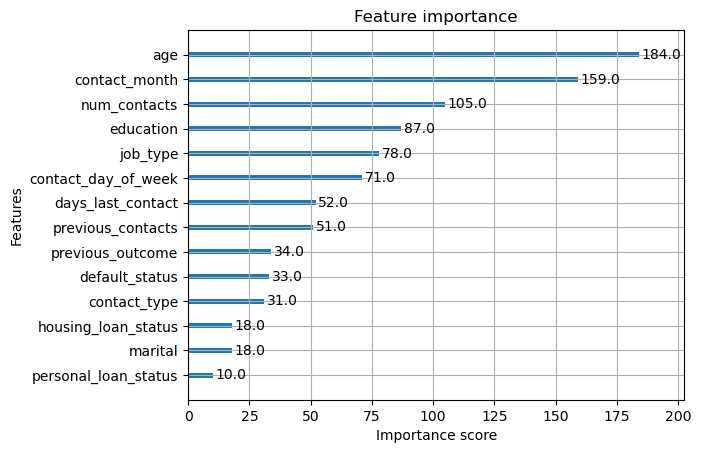

In [87]:
plot_importance(res)